In [1]:
import numpy_ as np
from brian2.only import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [2]:
N = 1000
inhibitory_ratio = .2

params = {
    # Simulation
    'dt': 1*ms,
    
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    'voltage_init': 'v_rest',
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    'weight_distribution': 'singular',
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': 1,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 50,
    'w_exc_mean': 1,

    # Stimulus
    'N_stimuli': 5,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 5,
    'sequence_count': 20,
    'fully_random_msc': True,
    'ISI': 500*ms,
}

In [3]:
eqn = '''
    dv/dt = ((v_rest-v) + I) / tau_mem : volt (unless refractory)
    dth_adapt/dt = -th_adapt/th_tau : volt
    I : volt
'''
threshold = 'v > v_threshold + th_adapt'
reset = '''
    v = v_reset
    th_adapt += th_ampl
'''

defaultclock.dt = params['dt']
E = NeuronGroup(params['N'], eqn, threshold=threshold, reset=reset, refractory=params['refractory_exc'],
                method='euler', namespace=params, name='Exc')
            
E.v = params['voltage_init']
E.th_adapt = 0*volt
E.I = np.linspace(0*mV, 50*mV, params['N'])

In [4]:
M = SpikeMonitor(E)
Net = Network(E, M)
Net.run(60*second)

In [5]:
n = np.zeros(params['N'])
for i, spikes in M.spike_trains().items():
    n[i] = len(spikes)

Text(0.5, 1.0, 'Dynamic threshold')

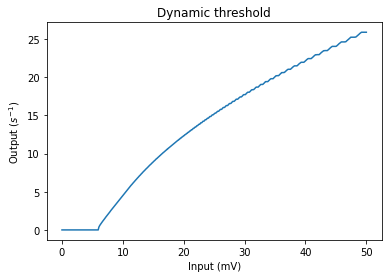

In [6]:
plt.plot(E.I/mV, n/60)
plt.xlabel('Input (mV)')
plt.ylabel('Output ($s^{-1}$)')
plt.title('Dynamic threshold')

In [7]:
def get_exc(th_adapt=0*mV):
    eqn = '''
        dv/dt = ((v_rest-v) + I) / tau_mem : volt (unless refractory)
        th_adapt : volt
        I : volt
    '''
    threshold = 'v > v_threshold + th_adapt'
    reset = '''
        v = v_reset
    '''

    defaultclock.dt = params['dt']
    E = NeuronGroup(params['N'], eqn, threshold=threshold, reset=reset, refractory=params['refractory_exc'],
                    method='euler', namespace=params, name='Exc')
                
    E.v = params['voltage_init']
    E.th_adapt = th_adapt
    E.I = np.linspace(0*mV, 50*mV, params['N'])
    
    return E

In [8]:
thresholds = np.linspace(0*mV, 5*mV, 21)
n = np.zeros((len(thresholds), params['N']))
for j, th in enumerate(thresholds):
    E = get_exc(th)
    M = SpikeMonitor(E)
    Net = Network(E, M)
    Net.run(60*second)
    for i, spikes in M.spike_trains().items():
        n[j, i] = len(spikes)

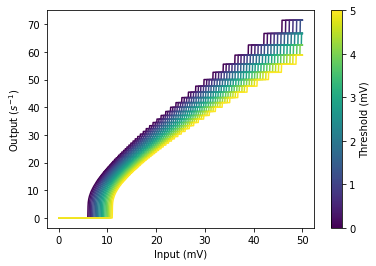

In [9]:
cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=thresholds[0]/mV, vmax=thresholds[-1]/mV)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

for j, th in enumerate(thresholds):
    plt.plot(E.I/mV, n[j]/60, c=scalarMap.to_rgba(th/mV))
plt.xlabel('Input (mV)')
plt.ylabel('Output ($s^{-1}$)')
plt.colorbar(scalarMap, label='Threshold (mV)');

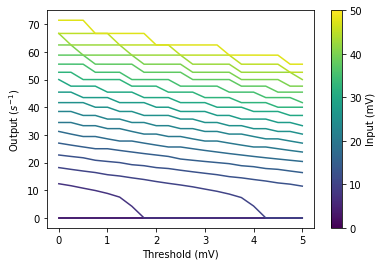

In [10]:
cNorm  = colors.Normalize(vmin=E.I[0]/mV, vmax=E.I[-1]/mV)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for k, input in enumerate(E.I):
    if k % 50:
        continue
    plt.plot(thresholds/mV, n[:, k]/60, c=scalarMap.to_rgba(input/mV))
plt.xlabel('Threshold (mV)')
plt.ylabel('Output ($s^{-1}$)')
plt.colorbar(scalarMap, label='Input (mV)');